In [1]:
# login to huggingface and generate api key

import io
import os
import re
import json
import torch
import html
import base64
import itertools

import numpy as np
from IPython.core.display import display, HTML
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont

C:\Users\f\AppData\Local\Temp\ipykernel_8416\3118209396.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import torch
from transformers import AutoModelForCausalLM

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_id = 'microsoft/Florence-2-large'
#model_id = 'microsoft/Florence-2-base'


# Load model onto the determined device
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).to(DEVICE)

processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)




## Custom training

In [3]:
# Define DetectionsDataset class

class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

In [4]:
# Initiate DetectionsDataset and DataLoader for train and validation subsets
BATCH_SIZE = 6
NUM_WORKERS = 0

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

train_dataset = DetectionDataset(
    jsonl_file_path = "custom_dataset/instruments_yolov8/train/images/train_annotations.json",
    image_directory_path = "custom_dataset/instruments_yolov8/train/images"
)
val_dataset = DetectionDataset(
    jsonl_file_path = "custom_dataset/instruments_yolov8/valid/images/val_annotations.json",
    image_directory_path = "custom_dataset/instruments_yolov8/valid/images"
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

In [5]:
# Setup LoRA Florence-2 model

config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 4,133,576 || all params: 826,827,464 || trainable%: 0.4999


In [6]:
torch.cuda.empty_cache()

C:\Users\f\.cache\huggingface\modules\transformers_modules\microsoft\Florence-2-large\15aa04e200389df2ccb00e2eb94d551284e45df1\modeling_florence2.py:1209: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


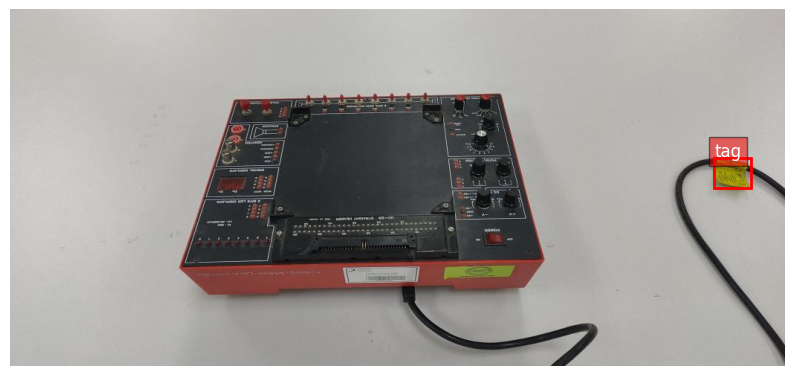

{'<OD>': {'bboxes': [[947.5654907226562,
    198.95999145507812,
    996.5864868164062,
    240.239990234375]],
  'labels': ['tag']}}

In [7]:
import matplotlib.pyplot as plt

def plot_bboxes_on_image(image, bboxes, labels):
    plt.figure(figsize=(10, 8))
    plt.imshow(image)

    ax = plt.gca()
    for bbox, label in zip(bboxes, labels):
        xmin, ymin, xmax, ymax = bbox
        width = xmax - xmin
        height = ymax - ymin
        rect = plt.Rectangle((xmin, ymin), width, height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin - 2, label, bbox=dict(facecolor='red', alpha=0.5), fontsize=12, color='white')

    plt.axis('off')
    plt.show()




def florence2_inference_results(model, dataset: DetectionDataset, count: int):
    count = min(count, len(dataset))
    for i in range(count):
        image, data = dataset.dataset[i]
        prefix = data['prefix']
        suffix = data['suffix']
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        #inputs = processor(text=prompt, images=image, return_tensors="pt")
    
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            early_stopping=False,
            do_sample=False,
            num_beams=3,
        )
        generated_text = processor.batch_decode(generated_ids,
                                                skip_special_tokens=False)[0]
        parsed_answer = processor.post_process_generation(
            generated_text,
            task='<OD>',
            image_size=(image.width, image.height))
        # Access bounding boxes and labels
        od_results = parsed_answer['<OD>']
        bboxes = od_results['bboxes']
        labels = od_results['labels']
        
        # Plot bounding boxes on the image using the separate function
        plot_bboxes_on_image(image, bboxes, labels)
    return parsed_answer


florence2_inference_results(peft_model, val_dataset, 1)

In [8]:
# training loop

def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    #florence2_inference_results(peft_model, val_loader.dataset, 3)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward(), optimizer.step(), lr_scheduler.step(), optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Average Validation Loss: {avg_val_loss}")

            florence2_inference_results(peft_model, val_loader.dataset, 2)

        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)

E:\microsoft_florence_env\myvenv\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/10: 100%|█████████████████████████████████████| 397/397 [2:41:34<00:00, 24.42s/it]


Average Training Loss: 4.848530517116902


Validation Epoch 1/10: 100%|███████████████████████████████████████| 21/21 [06:37<00:00, 18.91s/it]


Average Validation Loss: 2.0526760475976125


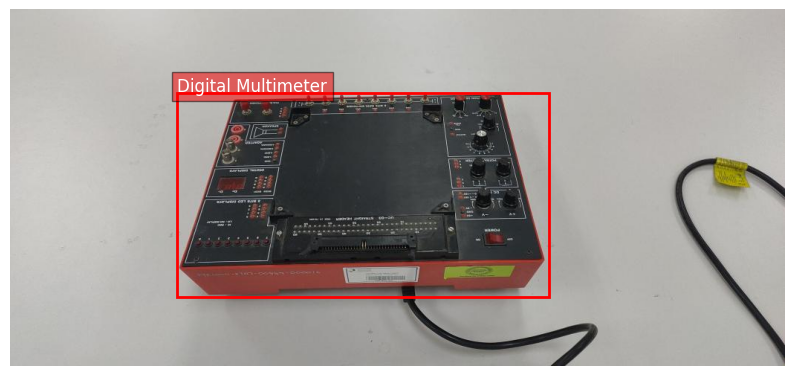

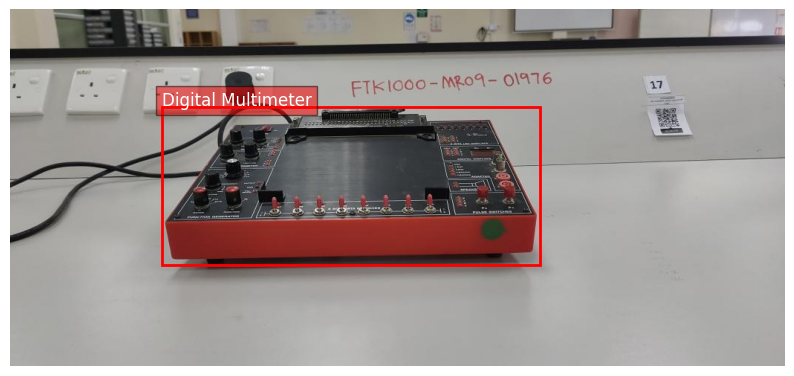

E:\microsoft_florence_env\myvenv\Lib\site-packages\peft\utils\save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
Training Epoch 2/10: 100%|█████████████████████████████████████| 397/397 [2:36:16<00:00, 23.62s/it]


Average Training Loss: 1.7503429122775869


Validation Epoch 2/10: 100%|███████████████████████████████████████| 21/21 [05:33<00:00, 15.89s/it]


Average Validation Loss: 1.4466434319814045


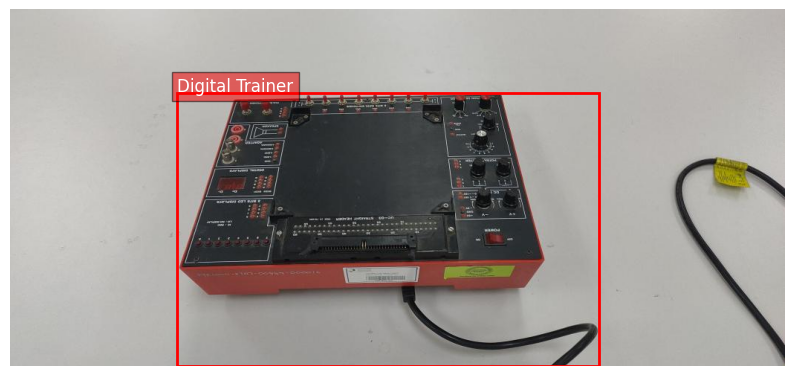

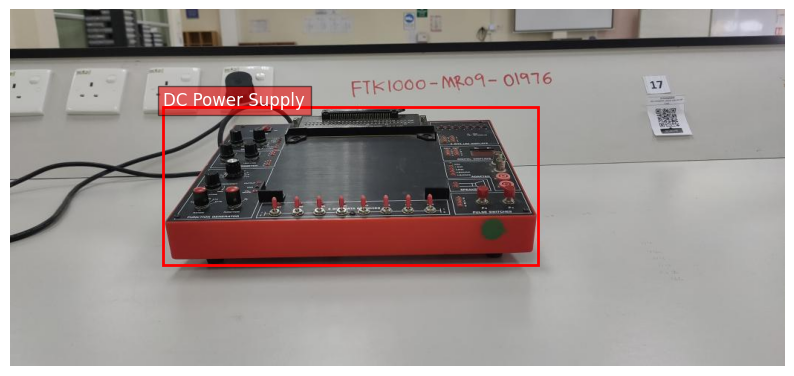

Training Epoch 3/10: 100%|█████████████████████████████████████| 397/397 [2:31:33<00:00, 22.91s/it]


Average Training Loss: 1.1589026370036513


Validation Epoch 3/10: 100%|███████████████████████████████████████| 21/21 [05:33<00:00, 15.90s/it]


Average Validation Loss: 1.377873074440729


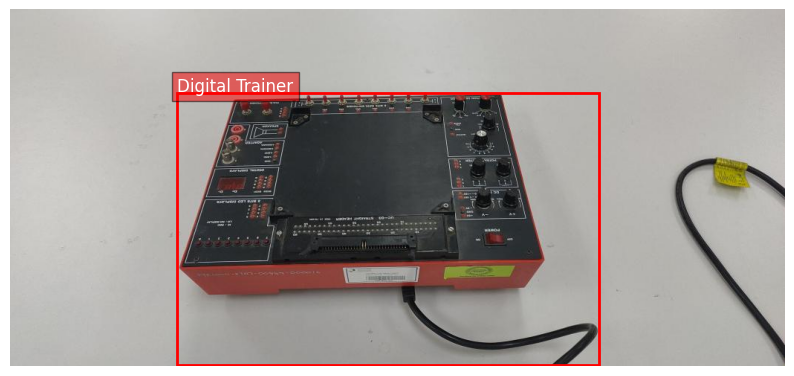

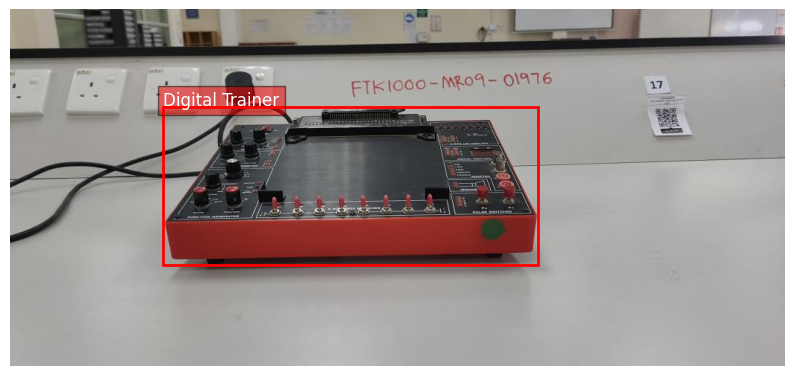

Training Epoch 4/10: 100%|█████████████████████████████████████| 397/397 [2:31:39<00:00, 22.92s/it]


Average Training Loss: 1.0589919330491226


Validation Epoch 4/10: 100%|███████████████████████████████████████| 21/21 [05:33<00:00, 15.89s/it]


Average Validation Loss: 1.3537089739527022


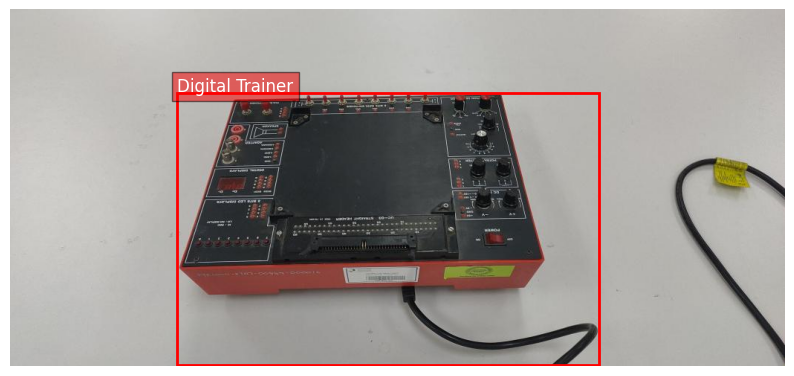

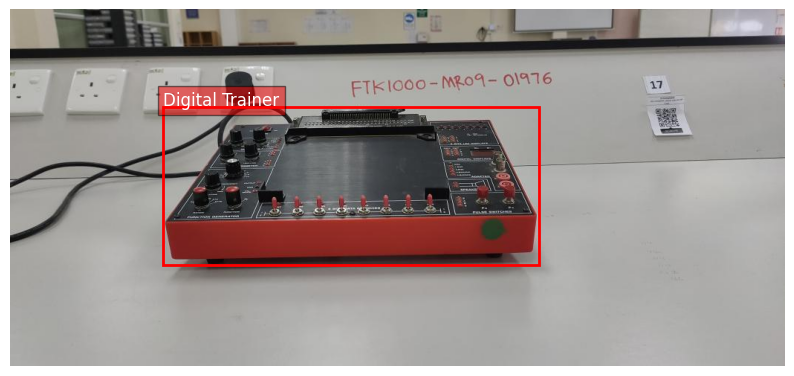

Training Epoch 5/10: 100%|█████████████████████████████████████| 397/397 [2:31:32<00:00, 22.90s/it]


Average Training Loss: 1.0219251391869648


Validation Epoch 5/10: 100%|███████████████████████████████████████| 21/21 [05:33<00:00, 15.90s/it]


Average Validation Loss: 1.3291547213281905


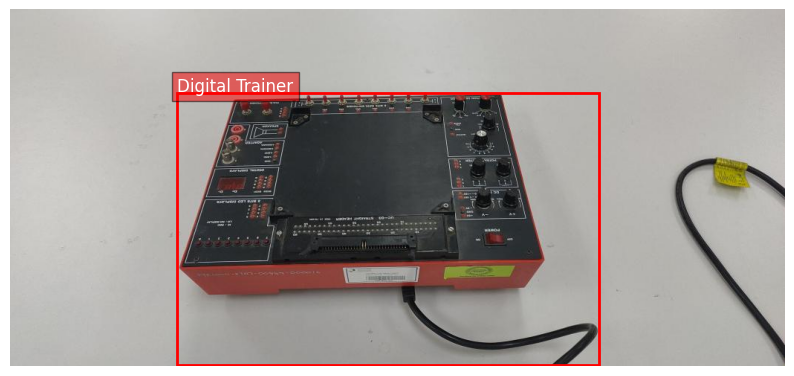

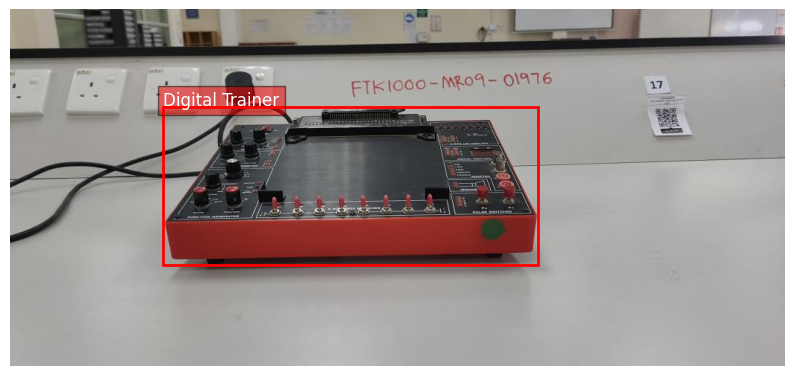

Training Epoch 6/10:  37%|█████████████▋                       | 147/397 [56:15<1:36:17, 23.11s/it]

In [ ]:
#  Training

EPOCHS = 10
LR = 4e-6
train_model(train_loader, val_loader, peft_model, processor, epochs=EPOCHS, lr=LR)